# Классификация комментариев

***Описание проекта:*** 

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

- `text` — текст комментария
- `toxic` — целевой признак

***План работы над проектом:***

1. Подготовка данных;
2. Обучение моделей; 
3. Общий вывод.

## Подготовка данных

In [1]:
!pip install catboost
!pip install imblearn
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install pandarallel

     |████████████████████████████████| 13.9 MB 2.1 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV)
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

from tqdm import tqdm, tqdm_notebook, notebook

from pandarallel import pandarallel
tqdm.pandas(desc="progress") 
pandarallel.initialize(progress_bar = True)

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

tqdm.pandas()
nltk.download('wordnet')
sns.set(rc={'figure.figsize': (10,7)})

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def start(df):
        df.info()
        print('\n',df.describe())
        display(df.sample(5))
        print('Количество пропусков в таблице:', df.isna().sum().sum(), '\n')
        print(df.isna().sum(), '\n')
        print('Количество дубликатов в таблице:',  df.duplicated().sum())
        df.hist(figsize=(10, 6));

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB

                toxic
count  159292.000000
mean        0.101612
std         0.302139
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


,text,toxic
35652,"""\nThere is a difference between Pink Floyd th...",0
52904,You might want to consider prodding Lara out o...,0
28799,Since all of this began I have read quite a lo...,0
71645,CAS2?\nCould somone expand this page to includ...,0
1972,"""\n\nAddressing:\nWhile """"Indian tribe"""" is of...",0


Количество пропусков в таблице: 0 

text     0
toxic    0
dtype: int64 

Количество дубликатов в таблице: 0


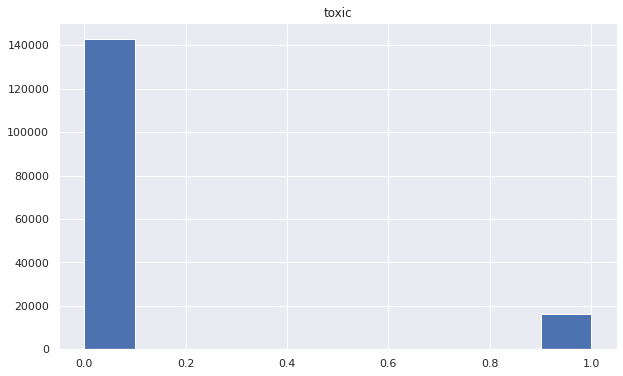

In [4]:
data = pd.read_csv('toxic_comments.csv', index_col=0)
# data = pd.read_csv('toxic_comments.csv')
start(data)

Для начала лематизарует наши текст попутно избавимся от стоп-слов. Напишем функцию.

In [5]:
corpus = data['text']

nlp = spacy.load('en_core_web_sm')

def lemmatize(text):
    # Преобразуем текст в объект docs
    docs = nlp(text.lower())

    # Собираем леммы в список
    lemmas = []
    for token in docs:
        if not token.is_stop:
            lemma = token.lemma_
            lemmas.append(lemma)

    # Объединяем леммы в строку с разделителем " "
    lemmatized_text = " ".join(lemmas)
    return lemmatized_text

print("Исходный текст:", corpus[0])
print("Лемматизированный текст:", lemmatize(corpus[0]))

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Лемматизированный текст: explanation 
 edit username hardcore metallica fan revert ? vandalism , closure gas vote new york doll fac . remove template talk page retire now.89.205.38.27


In [6]:
%%time
data['text'] = data['text'].progress_apply(lemmatize)
# data['text'] = data['text'].parallel_apply(lemmatize)
data.sample(3)

100%|██████████| 159292/159292 [55:02<00:00, 48.24it/s]  

CPU times: user 53min 27s, sys: 24.5 s, total: 53min 51s
Wall time: 55min 2s


,text,toxic
67563,thank mr / ms firsfron ronchester think answ...,0
28481,september 2015 ( utc ) \n fact lie repeat ass...,0
128040,""" welcome ! \n\n hello , , welcome wikipedia !...",0


Далее очистим текст от различных символов. Так же составим функцию и применим к столбцу таблицы.

In [7]:
corpus = data['text']
def clear_text(text):
    re_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    re_text = re_text.split()
    return " ".join(re_text)

print("Исходный текст:", corpus[0])
print("Обработанный текст:", clear_text(corpus[0]))

Исходный текст: explanation 
 edit username hardcore metallica fan revert ? vandalism , closure gas vote new york doll fac . remove template talk page retire now.89.205.38.27
Обработанный текст: explanation edit username hardcore metallica fan revert vandalism closure gas vote new york doll fac remove template talk page retire now


In [8]:
data['text'] = data['text'].progress_apply(clear_text)
data.sample(3)

100%|██████████| 159292/159292 [00:02<00:00, 70606.07it/s]


,text,toxic
87618,ambush massacre large number personally think ...,0
129295,dissident aggressor,0
63400,answer user talk page farmbrough farmbrough,0


Далее разобъём данные на обучающую и тестовую выборки. `(3|1)`

In [9]:
features = data['text']
target = data['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=123456)

print(features_train.shape[0])
print(features_test.shape[0])

119469
39823


Апсемплируем данные для обучения. Избавимся от дисбаланса классов.

In [10]:
def down_up_sample(features, target, fraction, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_down_up = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]*repeat)
    target_down_up = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]*repeat)
    
    features_down_up_sampled, target_down_up_sampled = shuffle(
        features_down_up, target_down_up, random_state=12345)
    
    return features_down_up_sampled, target_down_up_sampled

features_upsampled, target_upsampled  = down_up_sample(features_train, target_train, 0.6, 5)

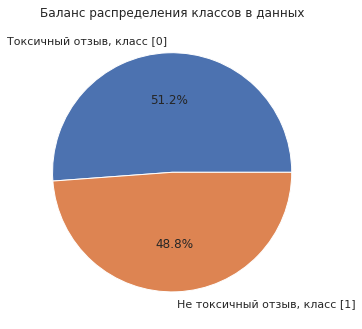

In [11]:
target_upsampled.value_counts(normalize=True).plot(
    kind='pie',
    figsize=[5.5, 5.5], 
    legend=False, 
    autopct='%1.1f%%',
    labels=['Токсичный отзыв, класс [0]','Не токсичный отзыв, класс [1]']
)

plt.title('Баланс распределения классов в данных')
plt.ylabel('')
plt.show()

Отлично! Далее переведём наши признаки из текста в векторный вид.

In [12]:
corpus_train = features_upsampled.values
corpus_test = features_test.values

count_tf_idf = TfidfVectorizer(ngram_range=(1, 2))

tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

print("Размер матрицы train:", tf_idf_train.shape)
print("Размер матрицы test:", tf_idf_test.shape)

Размер матрицы train: (125700, 1297744)
Размер матрицы test: (39823, 1297744)


**Вывод:** В начале работы мы загрузили данные в проект. У нас `3` столбца их которых нам нужны только `text и toxic`. Пропусков и дубликатов в столцах не было, но было видно, что наш целевой признак (`toxic`) имеет неравномерное количесвтво классов. Поэтому мы сделали апсемплирование данных для обучения. Пришли к балансу.

Так же при помощи библиотеки `spacy` мы обработали признаки, а именно сделали лемматизацию англоязычного текста и удалили не нужные символы и стоп-слова, чтобы они не создавали дополнитлеьный шум для моделей. Перевели признаки в векторный вид, установив значение параметра `ngram_range=(1, 2)`. Тем самым немного масштабируем данные, для лучшего понимания их моделями.

По итогу на этом этапе разделили данные на обучающую и тестовую выборки с соотношение `3 к 1`.

## Обучение моделей

Будем работать с `2` моделями. `LogisticRegression и DecisionTreeClassifier`. Для поиска лучших гиперпараметров будем использовать `GridSearchCV`.

Начнём с первой. `LogisticRegression`.

In [13]:
%%time
model = LogisticRegression(solver='liblinear', random_state=12345)

# зададим параметры
param_grid = {'C': [1, 10, 50, 100, 200]}

grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring='f1')
grid.fit(tf_idf_train, target_upsampled)

F1_lgr = grid.best_score_

print('Параметры лучшей модели:', grid.best_params_)
print('F1 лучшей модели:', F1_lgr)

Параметры лучшей модели: {'C': 200}
F1 лучшей модели: 0.986602474018054
CPU times: user 5min 34s, sys: 3min 4s, total: 8min 39s
Wall time: 8min 40s


И попробуем модель `DecisionTreeClassifier`.

In [14]:
%%time
model = DecisionTreeClassifier(random_state=12345)

# зададим параметры
param_grid = {'max_depth': [25, 30, 35, 40]}
              
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring='f1', verbose=True)
grid.fit(tf_idf_train, target_upsampled)

F1_rfc = grid.best_score_

print('Параметры лучшей модели:', grid.best_params_)
print('F1 лучшей модели:', F1_rfc)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Параметры лучшей модели: {'max_depth': 40}
F1 лучшей модели: 0.824667726043382
CPU times: user 39min 2s, sys: 6.18 s, total: 39min 8s
Wall time: 39min 10s


Сделаем проверку лучшей модели на тестовой выборке. В нашем случае это `LogisticRegression`.

In [15]:
model = LogisticRegression(solver='liblinear', C=200, random_state=12345)
model.fit(tf_idf_train, target_upsampled)
predicted = model.predict(tf_idf_test)

print(f1_score(target_test, predicted))

0.7707366043418246


**Вывод:** Мы обучили 2 полулярные, но разного между собой по принципу работы, модели. Это `LogisticRegression и DecisionTreeClassifier`. Для поиска лучших гиперпараметров использовали `GridSearchCV`. Как итог, лучшей на тренировочной выборке показала себя модель `LogisticRegression` со значением `f1=0.99`. На тестовой выборке результат метрики `0.77`.

## Общий вывод

В начале работы мы загрузили данные в проект. Пропусков и дубликатов в столцах не было, но было видно, что наш целевой признак (`toxic`) имеет неравномерное количесвтво классов. Поэтому мы сделали апсемплирование данных для обучения. Пришли к балансу.

Так же при помощи библиотеки `spacy` мы обработали признаки, а именно сделали лемматизацию англоязычного текста и удалили не нужные символы и стоп-слова, чтобы они не создавали дополнитлеьный шум для моделей. Перевели признаки в векторный вид, установив значение параметра `ngram_range=(1, 2)`. Тем самым немного масштабируем данные, для лучшего понимания их моделями.

По итогу на этом этапе разделили данные на обучающую и тестовую выборки с соотношение `3 к 1`.

Далее мы обучили `2` полулярные, но разного между собой по принципу работы, модели. Это `LogisticRegression и DecisionTreeClassifier`. Для поиска лучших гиперпараметров использовали `GridSearchCV`. Как итог, лучшей на тренировочной выборке показала себя модель `LogisticRegression` со значением `f1=0.99`. На тестовой выборке результат метрики `0.77` - можно рекомендовать нашу модель.